In [1]:
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cudatoolkit=11.3
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bzip2-1.0.8                |       h7f98852_4         484 KB  conda-forge
    ffmpeg-4.3                 |       hf484d3e_0         9.9 MB  pytorch
    gmp-6.2.1                  |       h58526e2_0         806 KB  conda-forge
    gnutls-3.6.13              |       h85f3911_1         2.0 MB  conda-forge
    lame-3.100                 |    h7f98852_1001         496 KB  conda-forge
    libiconv-1.17              |       h166bdaf_0         1.4 MB  conda-forge
    nettle-3.6                 |       he412f7d_0         6.5 MB  conda-forge
    openh264-2.1.1             |       h780b84a_0         1.5 MB  conda-forge
    torchaudio-0.11.0          |       py37_cu113     

In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


transform = transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomGrayscale(),
     transforms.RandomPerspective(),
     transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


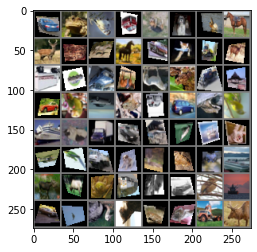

  car  frog  bird   car   dog   dog  bird horse  deer  frog horse horse   car   cat truck  deer truck   car   car horse horse  frog truck plane   car  bird   car  frog   car   car  frog  bird  ship   cat truck   car truck   cat  ship   dog plane  bird truck   dog  deer  frog  frog  ship  deer  deer  frog truck   cat  ship  bird  ship   car plane  bird   cat  frog   cat truck  deer


In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Set first filter 
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        # He initialization:
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')

        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')

        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')
      
        # Definebatch Normalization
        self.BN1 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN4 = nn.BatchNorm1d(128)

        # Define proportion or neurons to dropout
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)


        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(2048, 128)
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.BN1(self.conv1_2(F.relu(self.BN1(self.conv1_1(x)))))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.BN2(self.conv2_2(F.relu(self.BN2(self.conv2_1(x)))))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.BN3(self.conv3_2(F.relu(self.BN3(self.conv3_1(x)))))))
        x = self.dropout3(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.BN4(F.relu(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

net = Net().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


epoch = 400
TL = [0 for x in range(epoch)] #train loss
Tacc = [0 for x in range(epoch)] #train accuracy
VL = [0 for x in range(epoch)] #validation loss
Vacc = [0 for x in range(epoch)] #validation accuracy

for ep in range(epoch):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs,labels=inputs.to(device),labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        pred=outputs.argmax(dim=1,keepdim=True)
        train_acc += ((pred.eq(labels.view_as(pred)).sum().item())/(50000))
        
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0

    valid_loss = 0.0
    valid_acc = 0.0
    net.eval()     # Optional when not using Model Specific layer
    for inputs2, labels2 in testloader:
            inputs2,labels2=inputs2.to(device),labels2.to(device)
            # Forward Pass
            outputs2 = net(inputs2)
            # Find the Loss
            loss2 = criterion(outputs2,labels2)
            # Calculate Loss
            valid_loss += loss2.item()

            pred2=outputs2.argmax(dim=1,keepdim=True)
            valid_acc += ((pred2.eq(labels2.view_as(pred2)).sum().item())/(10000))

    TL[ep] = running_loss  
    Tacc[ep] = train_acc   
    VL[ep] = valid_loss
    Vacc[ep] = valid_acc

    print(f'Epoch {ep+1}/{epoch} \t Training Loss: {round(running_loss / len(trainloader),4)} \t Validation Loss: {round(valid_loss / len(testloader),4)} \t Training Accuracy: {round(train_acc,4)} \t Validation Loss:{round(valid_acc,4)}')

print('Finished Training')

Epoch 1/400 	 Training Loss: 2.1401 	 Validation Loss: 1.9295 	 Training Accuracy: 0.2076 	 Validation Loss:0.266
Epoch 2/400 	 Training Loss: 1.8758 	 Validation Loss: 1.8055 	 Training Accuracy: 0.2886 	 Validation Loss:0.3065
Epoch 3/400 	 Training Loss: 1.7804 	 Validation Loss: 1.7443 	 Training Accuracy: 0.3228 	 Validation Loss:0.3376
Epoch 4/400 	 Training Loss: 1.727 	 Validation Loss: 1.7008 	 Training Accuracy: 0.3427 	 Validation Loss:0.3559
Epoch 5/400 	 Training Loss: 1.6895 	 Validation Loss: 1.6584 	 Training Accuracy: 0.3608 	 Validation Loss:0.3704
Epoch 6/400 	 Training Loss: 1.6534 	 Validation Loss: 1.6505 	 Training Accuracy: 0.3748 	 Validation Loss:0.3813
Epoch 7/400 	 Training Loss: 1.632 	 Validation Loss: 1.6141 	 Training Accuracy: 0.3893 	 Validation Loss:0.3898
Epoch 8/400 	 Training Loss: 1.6058 	 Validation Loss: 1.5824 	 Training Accuracy: 0.397 	 Validation Loss:0.4025
Epoch 9/400 	 Training Loss: 1.5832 	 Validation Loss: 1.5757 	 Training Accuracy: 0

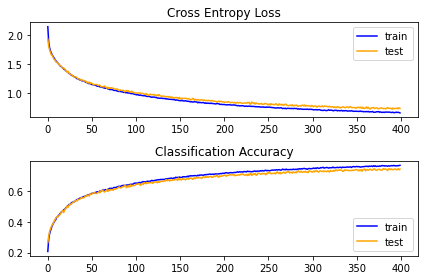

In [9]:
import sys
from matplotlib import pyplot
nTL= [x / len(trainloader) for x in TL]
nVL = [x / len(testloader) for x in VL]
# plot diagnostic learning curves
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(nTL, color='blue', label='train')
pyplot.plot(nVL, color='orange', label='test')
pyplot.legend(loc="upper right")
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(Tacc, color='blue', label='train')
pyplot.plot(Vacc, color='orange', label='test')
pyplot.legend(loc="lower right")
pyplot.tight_layout()
# save plot to file
# filename = sys.argv[0].split('/')[-1]
# pyplot.savefig(filename + '_plot.png')
# pyplot.close()


In [10]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data 
        images,labels=images.to(device),labels.to(device)
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
overall_acc = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 79.0 %
Accuracy for class car   is: 84.1 %
Accuracy for class bird  is: 64.6 %
Accuracy for class cat   is: 55.3 %
Accuracy for class deer  is: 68.7 %
Accuracy for class dog   is: 64.0 %
Accuracy for class frog  is: 80.0 %
Accuracy for class horse is: 78.2 %
Accuracy for class ship  is: 84.8 %
Accuracy for class truck is: 84.7 %
